In [101]:
# Common imports
import numpy as np
import numpy.random as rnd
import os
import sys
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import matplotlib.pyplot as plt
from scipy import misc
import math

# set parameters
p = 0.4 # the size of the encoding is p * target_width * target_height
read_dir = 'cats_and_dogs/'
batch_size = 100
target_width = 40
target_height = 40
n_epochs = 30
n_samples = 12500
max_learning_rate = 0.001
min_learning_rate = 0.000001
n_batches = n_samples // batch_size


decay_speed = math.pow( (min_learning_rate / (max_learning_rate - min_learning_rate)) , 1 / ( n_epochs * n_batches) )

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [102]:
# Loading the image sets

class data_feeder():
    def __init__(self,read_dir, target_width=100, target_height=100):
        self.read_dir = read_dir
        self.current_idx = 0
        self.w = target_width
        self.h = target_height

    def next_batch(self, batch_size):
        ret_list = list()
        #print(self.current_idx)
        for i in range(self.current_idx, self.current_idx + batch_size):
            pic = misc.imread(self.read_dir + 'cat.' + str(i) + '.jpg', flatten=True)
            #print(pic.shape)
            resized = misc.imresize(pic, (self.h, self.w))/256
            vectorized = resized.reshape((target_height*target_width,))
            ret_list.append(vectorized)
            self.current_idx += 1
            if self.current_idx >= n_samples:
                self.current_idx = 0
                break
        #print(self.current_idx)
        return np.asarray(ret_list, dtype='f')

catdog = data_feeder(read_dir, target_width, target_height)
first_batch = catdog.next_batch(100)
#print(first_batch.shape)
#print(first_batch)
second_batch = catdog.next_batch(100)
#print(second_batch.shape)
#print(second_batch)


In [103]:
# Useful Plotting Functions
def save_fig(fig_id, tight_layout=True):
    path = os.path.join("images/", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image, shape=[target_height, target_width]):
    plt.imshow(image.reshape(shape), cmap='Greys',interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap='Greys', interpolation="nearest")
    plt.axis("off")

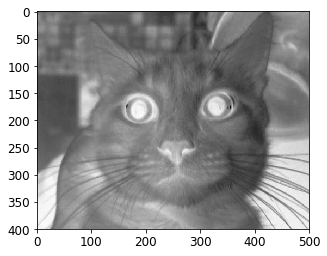

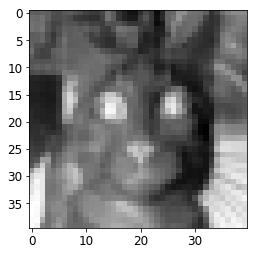

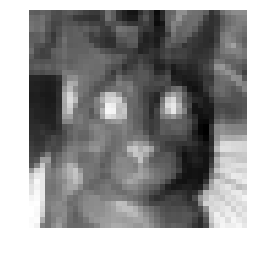

In [104]:
b = misc.imread('cats_and_dogs/cat.444.jpg', flatten=True)
c = misc.imresize(b, (target_height,target_width))/256

plt.imshow(b, cmap='Greys')
plt.show()

plt.imshow(c, cmap='Greys')
plt.show()

d = c.reshape((target_height*target_width,))
plot_image(d)

In [105]:
tf.reset_default_graph()

n_inputs = target_width*target_height # x pixels by y pixels
n_hidden1 = 1000
n_hidden2 = (int) (p*n_inputs)  # codings will be p% the size of the original image
n_hidden3 = n_hidden1
n_hidden4 = n_inputs


initializer = tf.contrib.layers.variance_scaling_initializer()

weights1_initializer = initializer([n_inputs, n_hidden1])
weights2_initializer = initializer([n_hidden1, n_hidden2])


X = tf.placeholder(tf.float32, [None, n_inputs])
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(max_learning_rate, global_step, n_batches, decay_speed)

w1 = tf.Variable(weights1_initializer, dtype=tf.float32)
w2 = tf.Variable(weights2_initializer, dtype=tf.float32)
w3 = tf.transpose(w2)
w4 = tf.transpose(w1)

b1 = tf.Variable(tf.zeros(n_hidden1))
b2 = tf.Variable(tf.zeros(n_hidden2))
b3 = tf.Variable(tf.zeros(n_hidden3))
b4 = tf.Variable(tf.zeros(n_inputs))

hidden1 = tf.nn.elu(tf.matmul(X, w1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, w2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, w3) + b3)
outputs = tf.sigmoid(tf.matmul(hidden3, w4) + b4)

reconstruction_loss = tf.reduce_sum(tf.square(outputs - X))
cost = reconstruction_loss

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training_op = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [106]:

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = catdog.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        cost_val, reconstruction_loss_val = sess.run([cost, reconstruction_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train cost:", cost_val, "\tReconstruction loss:", reconstruction_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train cost: 2704.9 	Reconstruction loss: 2704.9
1 Train cost: 1222.37 	Reconstruction loss: 1222.37
2 Train cost: 950.922 	Reconstruction loss: 950.922
3 Train cost: 818.354 	Reconstruction loss: 818.354
4 Train cost: 705.452 	Reconstruction loss: 705.452
5 Train cost: 658.27 	Reconstruction loss: 658.27
6 Train cost: 606.353 	Reconstruction loss: 606.353
7 Train cost: 577.224 	Reconstruction loss: 577.224
8 Train cost: 537.093 	Reconstruction loss: 537.093
9 Train cost: 547.562 	Reconstruction loss: 547.562
10 Train cost: 490.498 	Reconstruction loss: 490.498
11 Train cost: 477.893 	Reconstruction loss: 477.893
12 Train cost: 461.387 	Reconstruction loss: 461.387
13 Train cost: 457.415 	Reconstruction loss: 457.415
14 Train cost: 442.064 	Reconstruction loss: 442.064
15 Train cost: 431.56 	Reconstruction loss: 431.56
16 Train cost: 421.661 	Reconstruction loss: 421.661
17 Train cost: 407.772 	Reconstruction loss: 407.772
18 Train cost: 428.752 	Reconstruction loss: 428.752
19 Train 

In [107]:

n_digits = 10
X_test = catdog.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

In [108]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

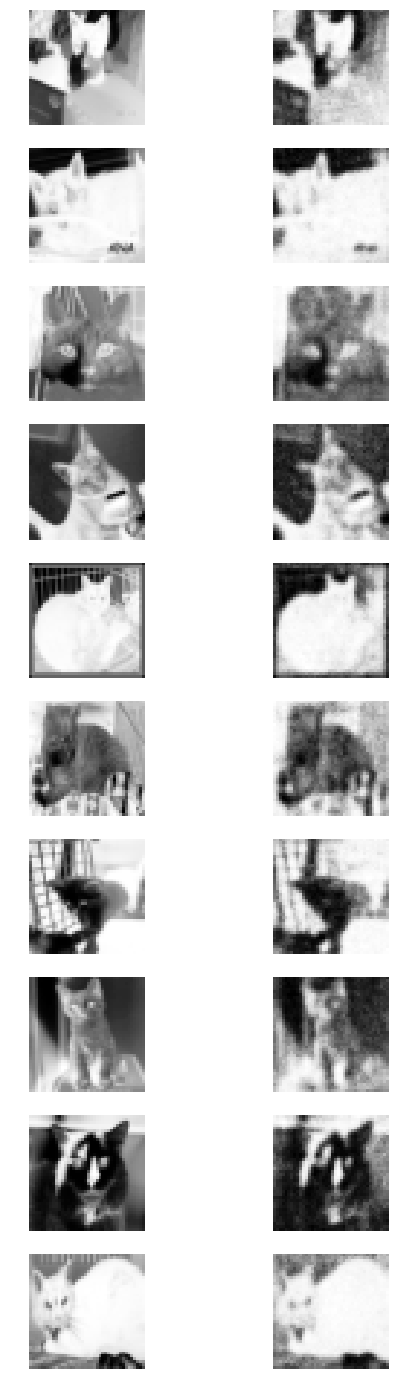

In [109]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])